<a id="subcluster_B"></a>
## Sub-cluster B-cells

Autosaving every 60 seconds


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


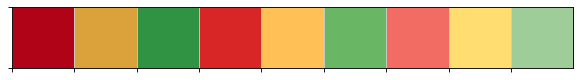

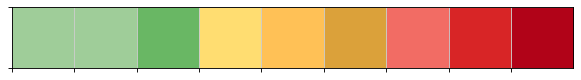

In [1]:
%matplotlib inline
%autosave 60
#%load_ext autoreload
#%autoreload 2


import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../../Code')
from utils import save_adata, read_adata, pca_cytof

import palettable
from IPython.display import display

from joblib import parallel_backend

from scipy.stats import ranksums

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

colors = np.array([x for x in palettable.tableau.TrafficLight_9.mpl_colors])
sns.palplot(colors)
sns.palplot(colors[[8,8,5, 7, 4, 1, 6,3,0], :])
dpimap = dict(zip(['0', '1', '2', '3', '4', '5', '6', '7', '8'], colors[[8,8,5, 7, 4, 1, 6,3,0], :]))
dpimap['0'] = palettable.tableau.TableauMedium_10.mpl_colors[-1]



In [2]:
adir = '../../../../../data/InVivo/Cytof/'
project_name = 'Full_IRF_SerialSac_Cytof_Fixid.1M'
results_dir = '../../../../../results'

gcs = False

In [5]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')

In [6]:
adata = read_adata(sample_file, ext='.h5ad', gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [7]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca

In [8]:
adata.obs['leiden_lab_group'].unique()

[Mono/DC, Neut, HLA-DR_high, Th, B, Plasmablast, NK, Tc, Doublet, RBC]
Categories (10, object): [Mono/DC, Neut, HLA-DR_high, Th, ..., NK, Tc, Doublet, RBC]

In [9]:
adata_B = adata[adata.obs['leiden_lab_group'].isin(['B', 'Plasmablast']),:]

In [10]:
adata_B = adata_B.copy()

In [11]:
adata_B.obsm = None

In [12]:
adata_B.obs.columns

Index(['BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1',
       'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI',
       'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode',
       'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1',
       'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5',
       'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width',
       'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context',
       'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab',
       'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample',
       'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12',
       'Subclustering', 'SubclusteringGroup', 'Doublet'],
      dtype='object')

In [13]:
adata_B.obs['leiden_lab'].value_counts()

B 1            157899
Plasmablast      1361
Name: leiden_lab, dtype: int64

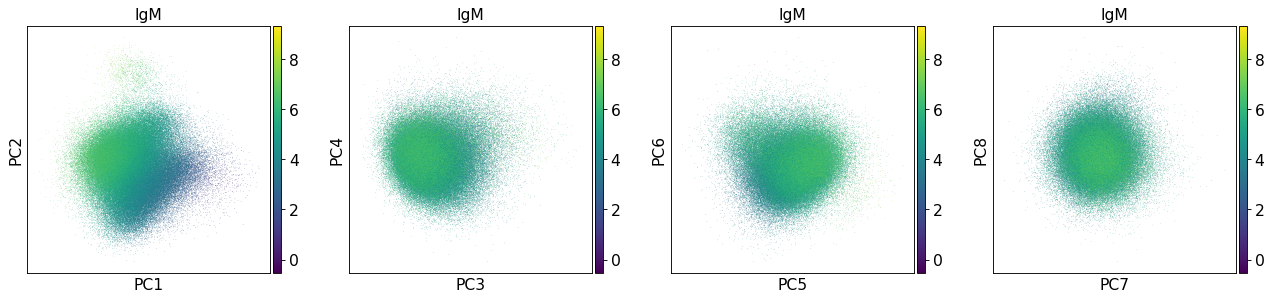

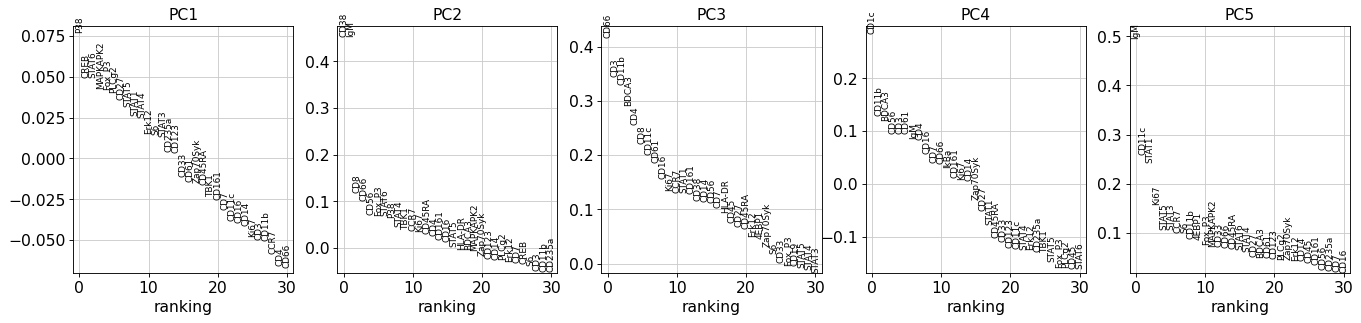

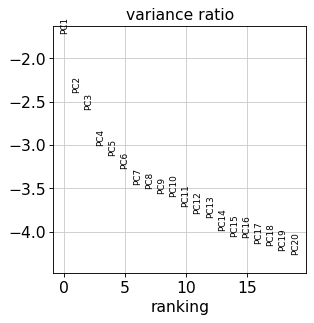

computing neighbors


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/numba/typed_passes.py:293: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../../../../../../../../../../opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  state.func_ir.loc))
/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../../..

    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:01:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:03:51)
running Leiden clustering
    finished: found 13 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:06:01)


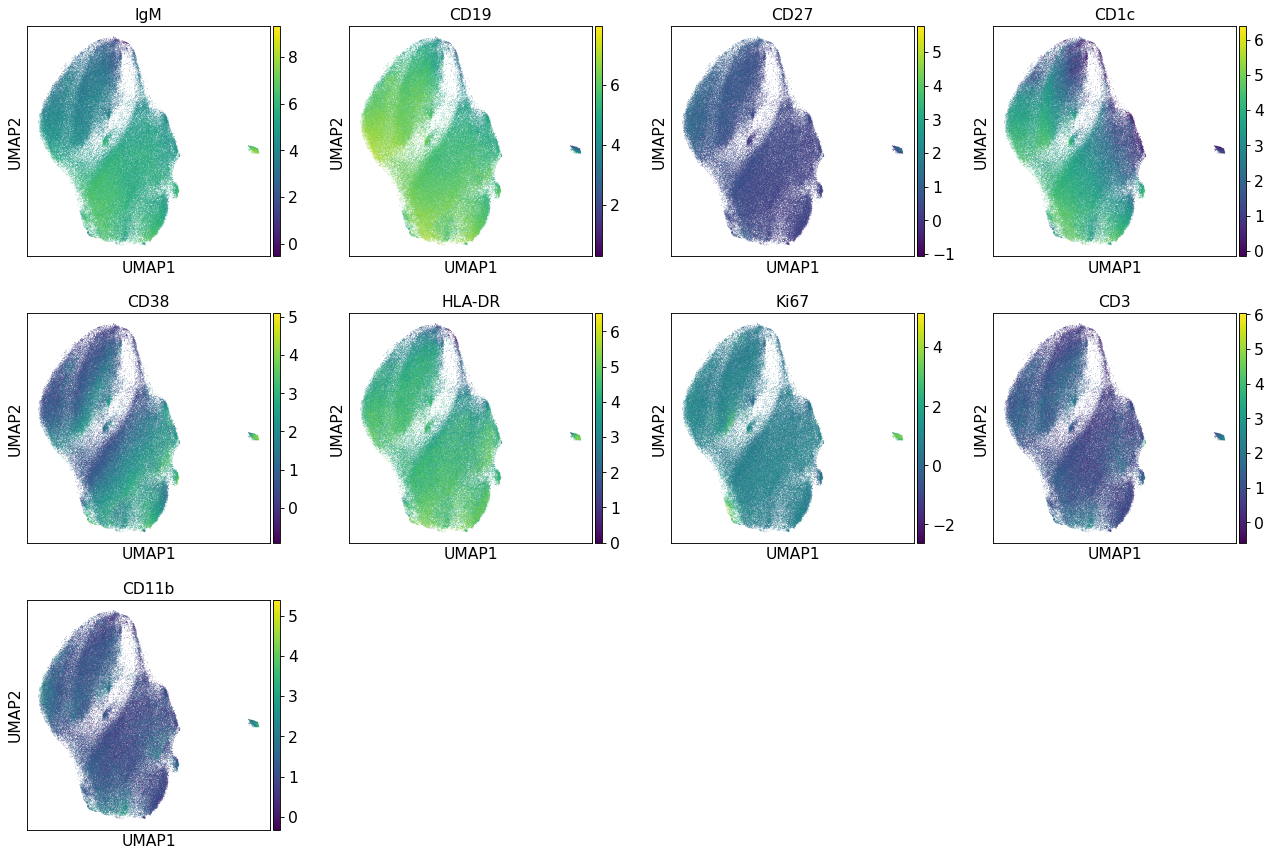

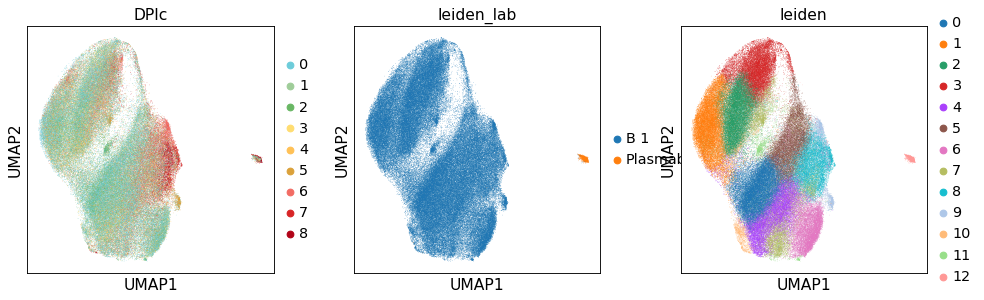

ranking genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:388: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,IgM,CD11c,CD27,CD27,CD38,MAPKAPK2,CD8,CD61,CD38,P38,Ki67,CD235a,Ki67
1,CD1c,CD45,CD19,STAT1,IgM,STAT6,CD38,BDCA3,Fox_P3,CD38,CD1c,STAT4,IgM
2,IkBa,CD19,CD235a,CREB,CD1c,PLCg2,IgM,CD4,STAT6,CD66,CD38,Fox_P3,CD66
3,CD56,CD27,CD1c,MAPKAPK2,CD19,P38,HLA-DR,CD11b,CCR7,CD56,CD11b,CD1c,CD38
4,CD235a,4EBP1,STAT1,PLCg2,HLA-DR,CREB,CD1c,CD3,CD66,IgM,CD3,STAT6,CD16
5,CD19,STAT1,CD33,P38,4EBP1,Fox_P3,TBK1,CD66,CD45RA,Zap70Syk,CD66,Ki67,CD11b
6,CD33,STAT3,CD3,STAT6,IkBa,STAT5,CREB,CD7,STAT4,CD11b,CD16,IkBa,BDCA3
7,CD123,CD33,CD123,Fox_P3,CD45,STAT4,P38,CD16,MAPKAPK2,CD8,CD45,CD16,CD14


,0,1,2,3,4,5,6,7,8,9,10,11,12
0,165.947311,215.493011,51.001709,44.048969,141.667740,47.416489,169.755600,144.399963,76.940811,93.831139,87.934334,77.510139,59.532013
1,115.591217,142.047943,38.923656,35.580238,125.064209,46.787476,95.668640,122.576012,75.091881,65.358009,43.300987,17.113842,54.881344
2,59.420048,129.461594,38.024963,34.040749,106.224274,42.244450,70.385460,104.922241,73.253716,45.447376,33.175022,13.802710,54.799076
3,30.714264,121.698486,35.218647,33.827507,105.218712,39.140289,66.592812,88.679474,66.352074,24.143023,32.261093,13.278681,53.098412
4,16.226717,86.408676,32.560097,32.530540,93.459572,38.454205,47.393265,81.238823,64.440308,10.225644,29.775846,12.728385,44.557308
5,15.557133,85.455322,29.794044,30.096691,88.017860,36.339745,46.745930,73.085320,55.310486,4.609525,27.445669,11.592194,43.525383
6,9.453025,80.800568,24.146254,29.625862,66.082726,27.000500,34.329441,68.413017,50.540154,3.965815,26.468599,11.337298,41.247185
7,8.630340,77.388504,19.390347,23.000664,55.892231,24.209047,31.017138,63.235115,42.951424,3.018170,24.737169,10.691138,33.746632


In [15]:
np.random.seed(14)
_adata = adata_B.copy()
npcs=15
n_neighbors=int(_adata.shape[0]*.0001)
min_dist=0.1
spread=2.0
resolution=1.
umap_genestoplot=['IgM', 'CD19', 'CD27', 'CD1c', 'CD38', 'HLA-DR', 'Ki67', 'CD3', 'CD11b']
pc_genestoplot='IgM'
other_plot=['DPIc', 'leiden_lab', 'leiden']
random_state=14

pca_cytof(_adata)
sc.pl.pca(_adata, components=['1,2', '3,4', '5,6', '7,8'], color=pc_genestoplot,
          ncols=4)
sc.pl.pca_loadings(_adata, components=[1,2,3,4,5])
sc.pl.pca_variance_ratio(_adata, log=True)

sc.pp.neighbors(_adata, n_neighbors=n_neighbors, n_pcs=npcs, random_state=random_state,
                    use_rep='X_pca')
sc.tl.umap(_adata, min_dist=min_dist, spread=spread, random_state=random_state)

np.random.seed(random_state)
sc.tl.leiden(_adata, resolution=resolution, random_state=random_state)
    
fig = sc.pl.umap(_adata, color=umap_genestoplot)
fig = sc.pl.umap(_adata, color=other_plot)

sc.tl.rank_genes_groups(_adata, 'leiden', method='wilcoxon')
display(pd.DataFrame(_adata.uns['rank_genes_groups']['names']).head(8))
display(pd.DataFrame(_adata.uns['rank_genes_groups']['scores']).head(8))
adata_B_1 = _adata.copy()

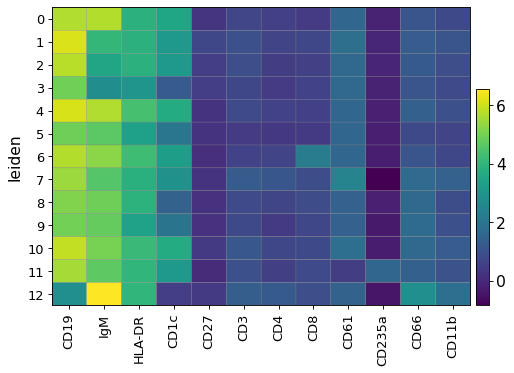

In [16]:
marker_genes = ['CD19', 'IgM', 'HLA-DR', 'CD1c', 'CD27', 'CD3', 'CD4', 'CD8', 'CD61', 'CD235a', 'CD66', 'CD11b']
gs = sc.pl.matrixplot(adata_B_1,marker_genes, groupby='leiden', figsize=(7,5))

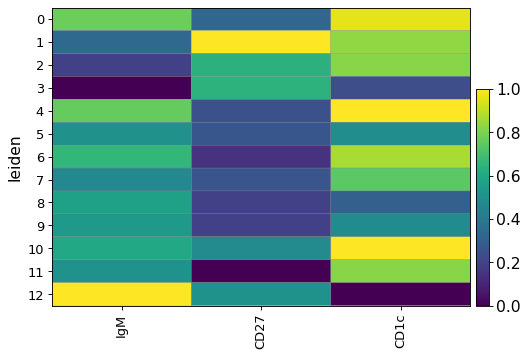

In [17]:
marker_genes = ['IgM', 'CD27', 'CD1c']
gs = sc.pl.matrixplot(adata_B_1,marker_genes, groupby='leiden', figsize=(7,5), standard_scale='var')

In [35]:
labmap ={'0':'B_IgMhi_CD27lo_CD1chi 1',
         '1':'B_IgMlo_CD27hi_CD1chi 1',
         '2':'B_IgMlo_CD27hi_CD1chi 2',
         '3':'B_IgMlo_CD27hi_CD1clo 1',
         '4':'B_IgMhi_CD27lo_CD1chi 2',
         '5':'B_IgMhi_CD27lo_CD1clo 1',
         '6':'B_IgMhi_CD27lo_CD1chi 3',
         '7':'B_IgMhi_CD27lo_CD1chi 4',
         '8':'B_IgMhi_CD27lo_CD1clo 2',
         '9':'B_IgMhi_CD27lo_CD1clo 3',
         '10':'B_IgMhi_CD27lo_CD1chi 5',
         '11':'B_IgMhi_CD27lo_CD1chi 6',
         '12':'Plasmablast 1'}

In [36]:
adata_B_1.obs['leiden_lab'] = adata_B_1.obs['leiden'].replace(labmap)

In [37]:
adata_B_1.obs['leiden_lab_group'] = adata_B_1.obs['leiden_lab'].apply(lambda x: ' '.join(x.split(' ')[:-1]))

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


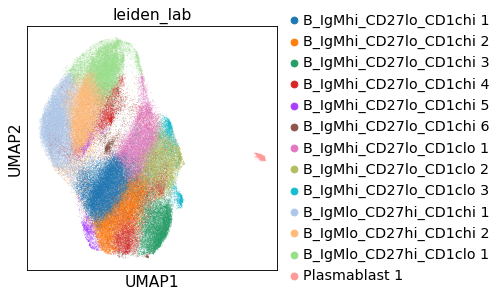

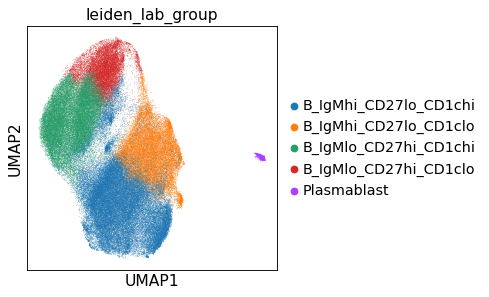

In [38]:
sc.pl.umap(adata_B_1, color='leiden_lab')
sc.pl.umap(adata_B_1, color='leiden_lab_group')

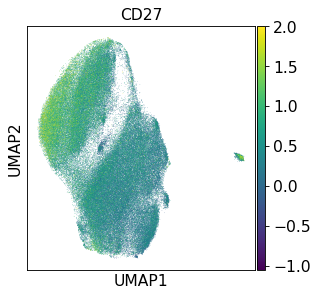

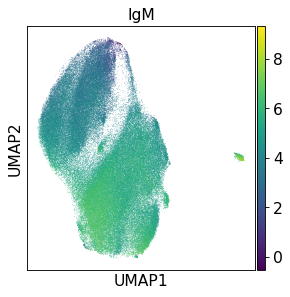

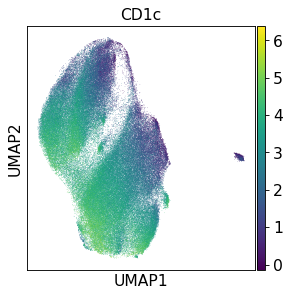

In [39]:
fig = sc.pl.umap(adata_B_1, color=['CD27'], vmax=2)
fig = sc.pl.umap(adata_B_1, color=['IgM'])
fig = sc.pl.umap(adata_B_1, color=['CD1c'])

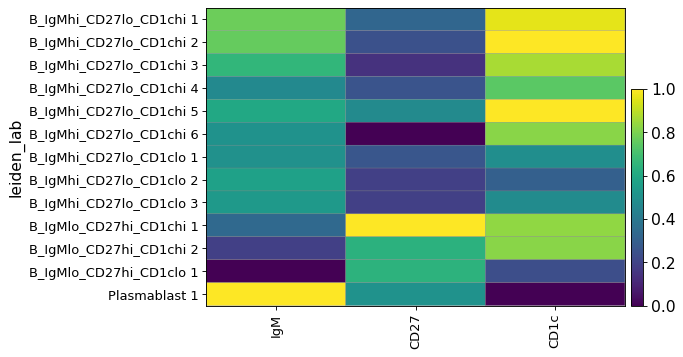

In [40]:
marker_genes = ['IgM', 'CD27', 'CD1c']
gs = sc.pl.matrixplot(adata_B_1,marker_genes, groupby='leiden_lab', figsize=(7,5), standard_scale='var')

In [41]:
adata_B_1.obs['leiden_lab_group'] = adata_B_1.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

In [42]:
sample_file = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.h5ad')
adata = read_adata(sample_file, gcs=gcs)

Only considering the two last: ['.Leiden', '.h5ad'].
Only considering the two last: ['.Leiden', '.h5ad'].


In [43]:
adata

AnnData object with n_obs × n_vars = 943558 × 42 
    obs: 'BCKG190Di_CKG', 'Ba138Di_Ba138Di', 'Center', 'Cs133Di_Environ', 'DNA1', 'DNA1_Norm', 'DNA2', 'DNA2_Norm', 'DNA_Norm_Sum', 'DNA_Sum_Norm', 'DPI', 'DPIc', 'Event_length', 'I127Di_127I', 'Multiplex_Barcode', 'Multiplex_Group', 'Offset', 'Pb208Di_Environ', 'Pd102Di_BC1', 'Pd104Di_BC2', 'Pd105Di_BC3', 'Pd106Di_BC4', 'Pd108Di_BC5', 'Pd110Di_BC6', 'Period', 'Residual', 'Sn120Di_Environ', 'Time', 'Width', 'Xe131Di_Environ', 'animal', 'batch', 'clinical_score', 'context', 'intensity_sum', 'is_doublet', 'leiden', 'leiden_lab', 'leiden_lab_group', 'n_counts', 'n_genes', 'num', 'samp', 'sample', 'sum_intensity', 'leiden14', 'leiden13', 'leiden10', 'leiden12', 'Subclustering', 'SubclusteringGroup', 'Doublet'
    var: 'gene_symbol', 'metal', 'full_id'
    uns: 'DPIc_colors', 'leiden', 'leiden10_colors', 'leiden12_colors', 'leiden13_colors', 'leiden14_colors', 'leiden_colors', 'leiden_lab_colors', 'leiden_lab_group_colors', 'neighbors', 'pca

In [44]:
adata.obs['Subclustering'] = adata.obs['Subclustering'].astype(str)
adata.obs['SubclusteringGroup'] = adata.obs['SubclusteringGroup'].astype(str)

In [45]:
adata.obs.loc[adata_B_1.obs.index, 'Subclustering'] = adata_B_1.obs['leiden_lab']
adata.obs.loc[adata_B_1.obs.index, 'SubclusteringGroup'] = adata_B_1.obs['leiden_lab_group']
adata.obs.loc[adata_B_1.obs.index[adata_B_1.obs['leiden_lab']=='Doublet'], 'Doublet'] = True

In [46]:
sample_file_B = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterB.h5ad')
print(sample_file_B)

../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.SubclusterB.h5ad


In [47]:
save_adata(adata, sample_file_B, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.SubclusterB', '.h5ad'].
Only considering the two last: ['.SubclusterB', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical


In [3]:
sample_file_Bonly = os.path.join(adir, project_name + '.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.BOnlyIter1.h5ad')
sample_file_Bonly

'../../../../../data/InVivo/Cytof/Full_IRF_SerialSac_Cytof_Fixid.1M.DoubletFilt.COMBAT.SubtractCNMF.UMAP.Leiden.BOnlyIter1.h5ad'

In [49]:
save_adata(adata_B_1, sample_file_Bonly, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.BOnlyIter1', '.h5ad'].
Only considering the two last: ['.BOnlyIter1', '.h5ad'].


... storing 'leiden_lab_group' as categorical


In [4]:
adata_B_1 = read_adata(sample_file_Bonly, ext='.h5ad', gcs=gcs)


Only considering the two last: ['.BOnlyIter1', '.h5ad'].
Only considering the two last: ['.BOnlyIter1', '.h5ad'].


## output figures

In [5]:
expression_full = pd.DataFrame(adata_B_1.X, index=adata_B_1.obs.index, columns=adata_B_1.var.index)

In [6]:
obs = adata_B_1.obs.copy()

In [7]:
genes_to_plot = ['IgM', 'CD27', 'CD19', 'CD1c']
celltype_order = ['Plasmablast', 'B_IgMhi_CD27lo_CD1chi', 'B_IgMhi_CD27lo_CD1clo', 'B_IgMlo_CD27hi_CD1chi', 'B_IgMlo_CD27hi_CD1clo']
celltype_order_clean = [x.replace('_', ' ') for x in celltype_order]
obs['Grouped_Clustering'] = pd.Categorical(obs['leiden_lab_group'].apply(lambda x: x.replace('_', ' ')).values, categories=celltype_order_clean)
expression = expression_full.loc[:, genes_to_plot]
obs['UMAP_1'] = adata_B_1.obsm['X_umap'][:,0]
obs['UMAP_2'] = adata_B_1.obsm['X_umap'][:,1]

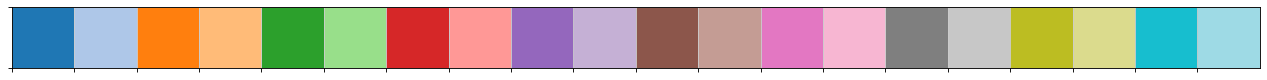

In [8]:
tableau = palettable.tableau.Tableau_20.hex_colors
sns.palplot(tableau)

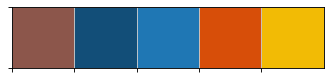

In [9]:
sns.palplot([tableau[10], '#124E78',tableau[0], '#D74E09', '#F2BB05'])

In [10]:
ctcolors = [tableau[10], '#124E78',tableau[0], '#D74E09', '#F2BB05']

ctmap = {'Plasmablast':ctcolors[0], 'B IgMhi CD27lo CD1chi':ctcolors[1], 'B IgMhi CD27lo CD1clo':ctcolors[2],
         'B IgMlo CD27hi CD1chi':ctcolors[3], 'B IgMlo CD27hi CD1clo':ctcolors[4]}

obs['ctcolor'] = obs['Grouped_Clustering'].replace(ctmap)

In [11]:
from matplotlib import gridspec
from matplotlib import rcParams

rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Myriad Pro']

rcParams['axes.titlesize'] = 9
rcParams['axes.labelsize'] = 9
rcParams['xtick.labelsize'] = 7
rcParams['ytick.labelsize'] = 7

rcParams['xtick.major.pad']='1'
rcParams['ytick.major.pad']='1'

rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

In [12]:
obs['Grouped_Clustering']

NHP08.D003.LIVE_138347-0    B IgMhi CD27lo CD1chi
NHP08.D-14.LIVE_86190-0     B IgMhi CD27lo CD1chi
NHP11.D005.LIVE_51601-0     B IgMlo CD27hi CD1chi
NHP11.D-04.LIVE_20151-0               Plasmablast
NHP12.D008.NEC_27170-0                Plasmablast
                                    ...          
NHPC2.D-02.NEC_59377-8                Plasmablast
NHPC2.D-02.NEC_113959-8               Plasmablast
NHPC2.D-02.NEC_120002-8               Plasmablast
NHPC3.D-02.NEC_10956-8                Plasmablast
NHPC3.D-02.NEC_1206-8                 Plasmablast
Name: Grouped_Clustering, Length: 159260, dtype: category
Categories (5, object): [Plasmablast, B IgMhi CD27lo CD1chi, B IgMhi CD27lo CD1clo, B IgMlo CD27hi CD1chi, B IgMlo CD27hi CD1clo]

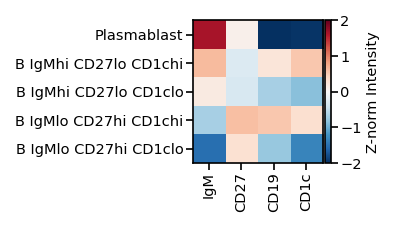

In [36]:
expression_norm = expression.copy()
expression_norm = expression_norm.subtract(expression_norm.mean(axis=0), axis=1)
expression_norm = expression_norm.divide(expression_norm.std(axis=0), axis=1)
average_expression = expression_norm.groupby(obs['Grouped_Clustering']).mean()

width=2.5
heatmap_width=1.55
legend_width=.64
left_space=.5

heatmap_height = .95
bottom_space = .42
top_space = .13
height=heatmap_height+bottom_space+top_space

topval = 1-(top_space/height)
bottomval = bottom_space/height

fig = plt.figure(figsize=(width, height), dpi=150)
full_gs = gridspec.GridSpec(
        nrows=1,
        ncols=2,
        wspace=0,
        hspace=0,
        width_ratios=[
            heatmap_width,
            legend_width,
        ], left=left_space, right=.99, bottom=bottomval, top=topval)


legend_grid = full_gs[0, 1].subgridspec(1, 130, wspace=0, hspace=0,
                                           width_ratios=[.01]*130)

cbar_ax = fig.add_subplot(legend_grid[5:20], ylim=[0,1], xlim=[0,1], frameon=False)
size_legend_ax = fig.add_subplot(legend_grid[50:], ylim=[0,1], xlim=[0,1], frameon=False, yticks=[], xticks=[])

heatmap_ax = fig.add_subplot(full_gs[0])

allcolors = average_expression.copy()
vmin=-2.
vmax=2.
cmap = "RdBu_r"

cim= heatmap_ax.imshow(allcolors.loc[celltype_order_clean, genes_to_plot], aspect='auto', cmap=cmap, vmin=vmin, vmax=vmax)
heatmap_ax.grid(False)
heatmap_ax.set_yticks(np.arange(len(celltype_order_clean)))
heatmap_ax.set_yticklabels(celltype_order_clean)

heatmap_ax.set_xticks(np.arange(len(genes_to_plot)))
heatmap_ax.set_xticklabels(genes_to_plot, rotation=90)        
#heatmap_ax.set_title('B - CyTOF', pad=0)


plt.colorbar(cim, cax=cbar_ax,)
#matplotlib.colorbar.ColorbarBase(cbar_ax, cmap=cmap, norm=normalize, ticks=[0,1,2,3,4,5,6,7])


vals = np.linspace(.2, 1, num=5)
leg_dot_size =  (vals * 10) ** 2
leg_dot_color = 'k'
text_offset = .2
leg_x_pos = .3

leg_x = np.array([leg_x_pos]*5)
leg_y = np.linspace(.45, .82, 5)

sizelegendfontsize = 7
size_legend_ax.text(.7, .5, 'Z-norm Intensity', fontsize=sizelegendfontsize, ha='left', va='center', rotation=90)
    
figure_file = os.path.join(results_dir, "Subcluster.B.Cytof.Invivo.Dotplot.pdf")
fig.savefig(figure_file, dpi=200)


In [33]:
box_height=1.5
box_width=1.5
title_height=.15
left_space = .02
right_space = .98
bottom_space = .02
top_space = .98

dotsize=.5
valdpi = 200

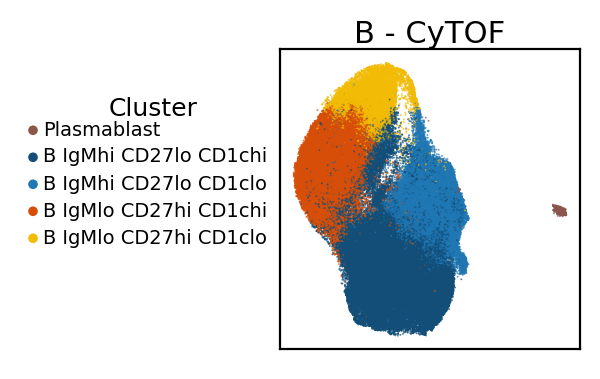

In [35]:
leg_width=1.3
ax_width = leg_width+box_width
fig_width = ax_width/(right_space-left_space)
ax_height = title_height+box_height
fig_height = ax_height/(top_space-bottom_space)
fig_width, fig_height

fig = plt.figure(figsize=(fig_width, fig_height), dpi=valdpi)
gs = gridspec.GridSpec(2, 2, fig,
                       left_space, bottom_space, right_space,top_space,
                       hspace=0.0, wspace=0.0,
                       width_ratios=(leg_width, box_width),
                       height_ratios=(title_height, box_height))

ax = fig.add_subplot(gs[1, 1],
          xscale='linear', yscale='linear',
          frameon=True, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])


ax.scatter(obs['UMAP_1'], obs['UMAP_2'], c=obs['ctcolor'],
           s=dotsize, alpha=.7, edgecolor='None', rasterized=True)

legend_ax = fig.add_subplot(gs[1, 0],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='',
          xticks=[], yticks=[])

legend_ax.set_ylim([0, 1])
legend_ax.set_xlim([0, 1])
marker_x=.05

N = len(celltype_order)
for (i,y) in enumerate(np.linspace(.73, .37, num=N)):
  ct = celltype_order_clean[i]
  legend_ax.scatter(marker_x, y, color=ctmap[ct], s=12, edgecolor='None')
  legend_ax.text(marker_x+.04, y-.015, ct, fontsize=7)
legend_ax.text(.34, .78, 'Cluster', fontsize=9)

title_ax = fig.add_subplot(gs[0, 1],
          xscale='linear', yscale='linear',
          frameon=False, ylabel='', xlabel='',
          title='', xlim=[0,1], ylim=[0,1],
          xticks=[], yticks=[])

title_ax.text(0.50, 1.0, 'B - CyTOF', va='top', ha='center',
              fontsize=11, fontdict=dict(weight='normal'),
              clip_on=False)

figure_file = os.path.join(results_dir, "Subcluster.UMAP.B.Cytof.Invivo.Celltype.pdf")
fig.savefig(figure_file, dpi=300)